In [1]:
import os
from tqdm import tqdm
from io import BytesIO
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard.writer import SummaryWriter
from torch.profiler import profile, record_function, ProfilerActivity
import torch
from model import GVAE
from loss import reconstruction_loss, kl_loss
from dataset import SketchDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data._utils.collate import default_collate
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
os.chdir('../')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = SketchDataset(root="data/")

generator = torch.Generator().manual_seed(4)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.033, 0.067], generator = generator)

print("Number of Graphs in total: ", dataset.len())
print("Number of Graphs for training: ", len(train_set))
print("Number of Graphs for validation: ", len(validate_set))
print("Number of Graphs for testing: ", len(test_set))

Number of Graphs in total:  4008985
Number of Graphs for training:  3608087
Number of Graphs for validation:  132297
Number of Graphs for testing:  268601


In [3]:
batch_size = 256
learning_rate = 1e-6
num_epochs = 20

In [4]:
# train_loader = DataLoader(dataset = train_set, batch_size = batch_size, persistent_workers = True, num_workers = 8, pin_memory = True)

In [5]:
# for batch_index, (nodes, edges, node_params_mask) in enumerate(train_loader):
#     nodes = nodes.to(device)
#     edges = edges.to(device)
#     node_params_mask = node_params_mask.to(device)
#     print(batch_index)

In [12]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True, persistent_workers = True, num_workers = 12)
validate_loader = DataLoader(dataset = validate_set, batch_size = batch_size, shuffle = True, persistent_workers = True, num_workers = 8)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True, persistent_workers = True, num_workers = 8)

model = GVAE(device)
if os.path.exists(f"best_model_checkpoint.pth"):
    model.load_state_dict(torch.load(f"best_model_checkpoint.pth"))

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

writer = SummaryWriter('runs/gvae_experiment_4')

In [7]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("data_loading"):
#         for i in range(10):
#             nodes, edges, params_mask = default_collate(train_set[i*batch_size:(1+i)*batch_size])
#             optimizer.zero_grad()

#             target_nodes = nodes.to(device)
#             target_edges = edges.to(device)
#             node_params_mask = node_params_mask.to(device)
    
#             pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)
    
#             loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)
#             loss.backward()
#             optimizer.step()

#         print("done")


In [8]:

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

In [5]:
def figure_to_tensor(figure):
    """
    Convert a Matplotlib figure to a PyTorch tensor.

    :param figure: Matplotlib figure to convert.
    :return: PyTorch tensor.
    """
    # Convert the Matplotlib figure to a NumPy array
    buf = BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    image = plt.imread(buf)

    # Convert the NumPy array to a PyTorch tensor
    transform = transforms.ToTensor()
    tensor = transform(image)

    return tensor

In [6]:
print(device)

cuda:1


In [ ]:
def train_model(model, train_loader, optimizer):
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    pbar = tqdm(train_loader)
    for target_nodes, target_edges, node_params_mask in pbar:
        optimizer.zero_grad()

        target_nodes = target_nodes.to(device)
        target_edges = target_edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        if (target_nodes.isnan().any()):
            raise ValueError("target nodes contain nan")
        if (target_edges.isnan().any()):
            raise ValueError("target edges contain nan")
        if (node_params_mask.isnan().any()):
            raise ValueError("param mask contain nan")
        if (pred_nodes.isnan().any()):
            raise ValueError("pred nodes contain nan")
        if (pred_edges.isnan().any()):
            raise ValueError("pred edges contain nan")
        if (means.isnan().any()):
            raise ValueError("means contain nan")
        if (logvars.isnan().any()):
            raise ValueError("logvars contain nan")
        
        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + 0.1*kl_loss(means, logvars)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Iter loss: {loss.item()} -")
        
        
        total_train_loss += loss.item()
        num_train_batches += 1
        # Log training loss every 100 mini-batches
        if num_train_batches % 100 == 99:
            avg_train_loss = total_train_loss / num_train_batches  # Calculate average up to the current batch
            writer.add_scalar("Training Loss", avg_train_loss, epoch * len(train_loader) + num_train_batches - 1)
    
    target_nodes = None
    target_edges = None
    node_params_mask = None
    torch.cuda.synchronize()

In [ ]:
def validate_model(model, validate_loader, writer):
    model.eval()
    total_validate_loss = 0.0
    num_validate_batches = 0
    for batch_idx, (nodes, edges, node_params_mask) in enumerate(tqdm(validate_loader)):
        target_nodes = nodes.to(device)
        target_edges = edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + 0.1*kl_loss(means, logvars)
        
        # Save an image pair of an input and output of model
        if num_validate_batches = 0:
            
        total_validate_loss += loss.item()
        num_validate_batches += 1
    
    # Calculate and log the average validation loss for this epoch
    avg_validate_loss = total_validate_loss / num_validate_batches  # Calculate average up to the last batch
    writer.add_scalar("Validation Loss", avg_validate_loss, epoch)
    
    
    return avg_validate_loss

In [ ]:
best_validation_loss = validate_model(model, validate_loader, writer)

for epoch in range(num_epochs):
    # Train Model for one epoch
    print(f"Epoch {epoch} Training model ---")
    train_model(model, train_loader, writer)
    
    # Validate Model at end of epoch
    print(f"Epoch {epoch} Validating model ---")
    avg_validate_loss = validate_model(model, validate_loader, writer)

    # Save the model checkpoint if the validation loss improves
    if avg_validate_loss < best_validation_loss:
        best_validation_loss = avg_validate_loss
        checkpoint_path = f"best_model_checkpoint.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint with validation loss: {best_validation_loss:.4f} to {checkpoint_path}")


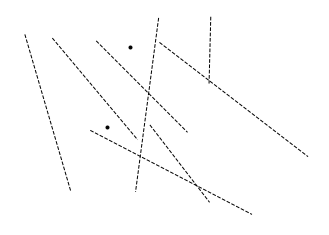

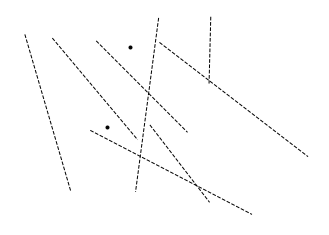

In [5]:
nodes, edges = model.sample_graph()
sketch = SketchDataset.preds_to_sketch(nodes.cpu(), edges.cpu())
datalib.render_sketch(sketch)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:

    
# for i in range(batch_size):
nodes, edges, node_params_mask = train_set[443*batch_size+508]#i]
target_nodes = nodes.to(device).unsqueeze(0)
target_edges = edges.to(device).unsqueeze(0)
node_params_mask = node_params_mask.to(device).unsqueeze(0)
    
#print(i)
#print(nodes.size(), edges.size(), node_params_mask.size())

    
pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

print
print(target_nodes)
print(pred_nodes)

loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)
loss.backward()

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0184,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0166,  0.0184, -0.0166,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000, -0.0166,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0184,
           0.0000,  0.0184, -0.0166,  0.0000,  0.0000,  0.0000,  0.0000,
          

/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [0,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATe

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
# for i in range(batch_size):
#     if (target_edges[i].isnan().any()):
#         print(i)
print(target_nodes[147])

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -5.6624e+13, -1.8216e+13, -5.6624e+13, -1.8216e+13,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -5.6624e+13, -1.8216e+13, -5.6624e+13, -1.8216e+13,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -5.6624e+13, -1.8216e+13, -5.6624e+13, -1.8216e+13,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -5.6624e+13, 

In [14]:
pred_nodes, pred_edges, mean, logvar = model(target_nodes[147].unsqueeze(0), target_edges[147].unsqueeze(0))
print(pred_nodes)

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 

In [15]:
print(target_nodes[:,:,0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:1')


In [ ]:

# Test Model
print(f"Testing model ---")
model.eval()
total_test_loss = 0.0
num_test_batches = 0
for batch_idx, (nodes, edges, node_params_mask) in enumerate(test_loader):
    target_nodes = nodes.to(device)
    target_edges = edges.to(device)
    node_params_mask = node_params_mask.to(device)

    pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)
    
    loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

    total_test_loss += loss.item()
    num_test_batches += 1

writer.add_scalar("Test Loss", total_test_loss / num_test_batches)


torch.Size([24, 20])
torch.Size([24, 24, 17])
Sketch(n_entities=21, n_constraints=29)


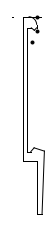

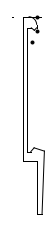

In [18]:
# model.eval()
# nodes, edges = model.sample_graph()
print(nodes.shape)
print(edges.shape)
sketch = SketchDataset.preds_to_sketch(nodes.cpu(), edges.cpu())
print(sketch)
datalib.render_sketch(sketch)

In [8]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
